
# Big Data Analytics


>**Goals:**

Create Apache Spark environment (distributed data processing)

Dataset loading with more than 3 million rows

Data exploration and analysis using RDD and sparksql

Implementing Machine Learning with spark.ml


## Create Spark Environment in Google Colab

In [1]:
# Hide all warnings
import warnings
warnings.filterwarnings('ignore')
# Install pyspark
!pip install pyspark --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create the Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session information

## Dataset yelp

https://www.yelp.com/dataset

Yelp dataset refers to data collected and made available by Yelp for research, analysis and application development purposes.
Contains detailed information about businesses registered on Yelp, as well as user ratings and reviews.

5 json files are available for download:

> business.json

Contains business data including location data, attributes and categories.

> review.json

Contains complete data from the review text, including the user_id you wrote and the business_id the review was written for.

> user.json

User data, including the user's friend mapping and all metadata associated with the user.

> checkin.json

Checkins num negocio.

> tip.json

Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

In this work I will use the files "business.json" and "review.json".

## Import json data files directly from Kaggle

>We use the Kaggle API to download the two necessary files.

In [3]:
# Install kaggle in the environment
!pip install kaggle --quiet
# Ask for json file with password
# This json file has to be retrieved from the kaggle personal account following the steps: 1- settings 2-create New Token
from google.colab import files
files.upload()
# Storage location in the environment
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Change permission to avoid warning during Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json
# Copy API address for dataset download
!kaggle datasets download -d yelp-dataset/yelp-dataset -f yelp_academic_dataset_review.json
!kaggle datasets download -d yelp-dataset/yelp-dataset -f yelp_academic_dataset_business.json
# unzip the file
!unzip \*.zip  && rm *.zip

Saving kaggle.json to kaggle.json
100% 2.06G/2.07G [00:23<00:00, 146MB/s]
100% 2.07G/2.07G [00:24<00:00, 89.1MB/s]
 87% 18.0M/20.8M [00:00<00:00, 42.9MB/s]
100% 20.8M/20.8M [00:00<00:00, 45.6MB/s]
Archive:  yelp_academic_dataset_review.json.zip
  inflating: yelp_academic_dataset_review.json  

Archive:  yelp_academic_dataset_business.json.zip
  inflating: yelp_academic_dataset_business.json  

2 archives were successfully processed.


In [4]:
# Loading files into dataframe variables
df_review = spark.read.json("/content/yelp_academic_dataset_review.json")
df_business = spark.read.json("/content/yelp_academic_dataset_business.json")

## Information about dataframes created in spark environment

In [5]:
# Check number of partitions created by spark for each dataframe
print('\nO numero de partições:\nreview:\n',df_review.rdd.getNumPartitions(),'\nbusiness:\n',df_business.rdd.getNumPartitions())


O numero de partições:
review:
 40 
business:
 2


In [6]:
# View the number of executors
spark._jsc.sc().getExecutorMemoryStatus().size()

1

In [7]:
# See amounts of records stored in each partition example df_review

# Convert dataframe to RDD
rdd_review= df_review.rdd
# Get total number of partitions
num_particoes = rdd_review.getNumPartitions()
# Simple function to count the number of records in a partition
def countRecords(partition):
    yield len(list(partition))
# Apply the function to each partition and return a list with the number of records
NumRecordsPartition = rdd_review.mapPartitions(countRecords).collect()
# Prints the number of records in each partition
for i, num_records in enumerate(NumRecordsPartition):
    print(f"Partition {i}: {num_records} records")

Partition 0: 179996 records
Partition 1: 177922 records
Partition 2: 175357 records
Partition 3: 167630 records
Partition 4: 180328 records
Partition 5: 178376 records
Partition 6: 177601 records
Partition 7: 167685 records
Partition 8: 179745 records
Partition 9: 179090 records
Partition 10: 177468 records
Partition 11: 169150 records
Partition 12: 177148 records
Partition 13: 178281 records
Partition 14: 174820 records
Partition 15: 168089 records
Partition 16: 179099 records
Partition 17: 177017 records
Partition 18: 175919 records
Partition 19: 167132 records
Partition 20: 181561 records
Partition 21: 178363 records
Partition 22: 176465 records
Partition 23: 167997 records
Partition 24: 180102 records
Partition 25: 177189 records
Partition 26: 175273 records
Partition 27: 166935 records
Partition 28: 182093 records
Partition 29: 179347 records
Partition 30: 176906 records
Partition 31: 168248 records
Partition 32: 181395 records
Partition 33: 178860 records
Partition 34: 174603 rec

## Explore Dataframes

In [8]:
# View review table schema
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [9]:
# View business table schema
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [10]:
# Number of records dataframe review
df_review.count()

6990280

In [ ]:
# First row of review dataframe
df_review.first()

Row(business_id='XQfwVwDr-v0ZS3_CbbE5Xw', cool=0, date='2018-07-07 22:09:11', funny=0, review_id='KU_O5udG6zpxOg-VcAEodg', stars=3.0, text="If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", useful=0, user_id='mh_-eMZ6K5RLWhZyISBhwA')

In [ ]:
# Number of records dataframe business
df_business.count()

150346

In [ ]:
# First row of business dataframe
df_business.first()

Row(address='1616 Chapala St, Ste 2', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking=None, BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards=None, BusinessParking=None, ByAppointmentOnly='True', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2=None, RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='Pns2l4eNsfO8kk83dixA6A', categories='Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, 

In [11]:
# View the type of dataframe
print('\n Tipos\nreview :',type(df_review),'\nbusiness :',type(df_business))


 Tipos
review : <class 'pyspark.sql.dataframe.DataFrame'> 
business : <class 'pyspark.sql.dataframe.DataFrame'>


## Explore data with Spark.sql

In [12]:
# Create  the temp tables for sql queries
df_review.createOrReplaceTempView('review')
df_business.createOrReplaceTempView('business')

In [ ]:
# Count records in sql language from both tables
result = spark.sql(
    '''
    SELECT 'review' as table, COUNT(*) as row_count
    FROM review
    UNION ALL
    SELECT 'business' as table, COUNT(*) as row_count
    FROM business
    '''
).show()

+--------+---------+
|   table|row_count|
+--------+---------+
|  review|  6990280|
|business|   150346|
+--------+---------+



In [ ]:
# Count the distinct business_id and users_id in the review table
result = spark.sql(
    '''
    SELECT
      COUNT(DISTINCT business_id) as total_business,
      COUNT(DISTINCT user_id) as total_user
    FROM review
    '''
).show()

+--------------+----------+
|total_business|total_user|
+--------------+----------+
|        150346|   1987929|
+--------------+----------+



In [ ]:
# See minimum and maximum date of records in the review table
result = spark.sql(
    '''
    SELECT
      MIN(date) as min_date,
      MAX(date) as max_date
    FROM review
    '''
).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2005-02-16 03:23:22|2022-01-19 19:48:45|
+-------------------+-------------------+



In [ ]:
# Count business_id by category
result = spark.sql(
    '''
    SELECT
      categories,
      COUNT(business_id) as total_business
    FROM business
    GROUP BY categories
    ORDER BY total_business DESC
    '''
).show()

+--------------------+--------------+
|          categories|total_business|
+--------------------+--------------+
|Beauty & Spas, Na...|          1012|
|  Restaurants, Pizza|           935|
|Nail Salons, Beau...|           934|
|  Pizza, Restaurants|           823|
|Restaurants, Mexican|           728|
|Restaurants, Chinese|           708|
|Mexican, Restaurants|           672|
|Chinese, Restaurants|           651|
|  Food, Coffee & Tea|           508|
|Beauty & Spas, Ha...|           493|
|Hair Salons, Beau...|           480|
|  Coffee & Tea, Food|           473|
|Automotive, Auto ...|           361|
|Auto Repair, Auto...|           351|
|       Grocery, Food|           329|
|Italian, Restaurants|           328|
|       Food, Grocery|           306|
| Veterinarians, Pets|           300|
|Ice Cream & Froze...|           298|
|Restaurants, Italian|           285|
+--------------------+--------------+
only showing top 20 rows



In [ ]:
# See how many business_id there are with the word 'Restaurants' in categories
result = spark.sql(
    '''
    SELECT
      COUNT(business_id) as total_business
    FROM business
    WHERE categories LIKE '%Restaurants%'
    '''
).show()

+--------------+
|total_business|
+--------------+
|         52268|
+--------------+



In [13]:
# Join between the 2 tables filtering the category with the word 'Restaurants'
result = spark.sql(
    '''
    WITH rest_review AS (
        SELECT
            r.business_id as r_business_id,
            r.cool,
            r.funny,
            r.text,
            r.useful,
            r.stars as  stars_r
        FROM review as r
    ), rest_business AS (
        SELECT
            b.attributes,
            b.business_id,
            b.stars
        FROM business as b
        WHERE b.categories LIKE '%Restaurants%'
    )
    SELECT
        *
    FROM rest_review
    JOIN rest_business as b ON business_id = rest_review.r_business_id
    '''
)

## Data preparation

In [14]:
# Count records resulting from the Join made in the sql query made previously
result.count()

4724471

In [15]:
# Check columns of the dataframe result
result.columns

['r_business_id',
 'cool',
 'funny',
 'text',
 'useful',
 'stars_r',
 'attributes',
 'business_id',
 'stars']

In [ ]:
# Check for missing values
from pyspark.sql.functions import col, sum
null_counts=result.select([sum(col(c).isNull().cast("int")).alias(c) for c in result.columns])
# Filters columns that have null values
columns_with_nulls = null_counts.select(*[
    col(c).alias(c + '_null_count')
    for c in null_counts.columns
    if null_counts.select(col(c)).head()[0] > 0
])
# Displays columns with null values ​​and their quantities
columns_with_nulls.show()

+---------------------+
|attributes_null_count|
+---------------------+
|                 5069|
+---------------------+



In [16]:
# Delete existing records with null
result1 = result
result1= result1.dropna()

In [17]:
# Select only the columns we are going to use
df_attributes = result1.select('attributes','stars','cool','funny','useful')
df_attributes.columns

['attributes', 'stars', 'cool', 'funny', 'useful']

The "attributes" column contains various information about the business.
This information is not structured data it can be strings, boolean, or json structures.
Let's do the exploration and treatment of this data.

In [ ]:
# View 2 rows of 'attributs' column
df_attributes.select('attributes').take(2)

[Row(attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="u'none'", Ambience="{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': True, 'casual': False}", BYOB='True', BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin='False', BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly=None, Caters='True', CoatCheck=None, Corkage='False', DietaryRestrictions=None, DogsAllowed='True', DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV='False', Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating='True', RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery='False', RestaurantsGoodForGroups=None, RestaurantsPriceRange2=None, RestaurantsReservations='False', RestaurantsTable

In [19]:
# Expand attributes object in dataframe and see resulting columns
df_attributes1 = df_attributes.select("attributes.*")
df_attributes1.columns

['AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

In [20]:
# The Ambience ,BusinessParking and GoodForMeal columns contain a Json string object, let's remove these columns
columns_to_drop = ['Ambience', 'BusinessParking', 'GoodForMeal','BestNights','Music', 'DietaryRestrictions','HairSpecializesIn']
df_attributes2 = df_attributes1.drop(*columns_to_drop)
df_attributes2.printSchema()

root
 |-- AcceptsInsurance: string (nullable = true)
 |-- AgesAllowed: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BYOBCorkage: string (nullable = true)
 |-- BikeParking: string (nullable = true)
 |-- BusinessAcceptsBitcoin: string (nullable = true)
 |-- BusinessAcceptsCreditCards: string (nullable = true)
 |-- ByAppointmentOnly: string (nullable = true)
 |-- Caters: string (nullable = true)
 |-- CoatCheck: string (nullable = true)
 |-- Corkage: string (nullable = true)
 |-- DogsAllowed: string (nullable = true)
 |-- DriveThru: string (nullable = true)
 |-- GoodForDancing: string (nullable = true)
 |-- GoodForKids: string (nullable = true)
 |-- HappyHour: string (nullable = true)
 |-- HasTV: string (nullable = true)
 |-- NoiseLevel: string (nullable = true)
 |-- Open24Hours: string (nullable = true)
 |-- OutdoorSeating: string (nullable = true)
 |-- RestaurantsAttire: string (nullable = true)
 |-- RestaurantsCounterService: s

In [21]:
# Knowing that the type of all columns is 'string', we will remove spaces that may exist
from pyspark.sql.functions import trim
from pyspark.sql.functions import  col
for column in df_attributes2.columns:
    df_attributes2 = df_attributes2.withColumn(column, trim(col(column)))

In [ ]:
# View 6 columns of the resulting Dataframe
df_attributes2.select('AcceptsInsurance','Alcohol','DriveThru','Smoking','WiFi','BikeParking').show()

+----------------+-------+---------+-------+-----+-----------+
|AcceptsInsurance|Alcohol|DriveThru|Smoking| WiFi|BikeParking|
+----------------+-------+---------+-------+-----+-----------+
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|       True|
|            null|u'none'|     null|   null|u'no'|     

In [ ]:
# In this transformation we will replace the values ​​None(missing values) or 'None' by the string '0.5'
from pyspark.sql.functions import when, isnull
df_attributes3 = df_attributes2
# Loop over all columns
for column in df_attributes2.columns:
    # Replaces the string "None" with "0.5"
    df_attributes3 = df_attributes3.withColumn(column, when(col(column) == "None", "0.5").otherwise(col(column)))
    # Replaces is null with 0.5
    df_attributes3 = df_attributes3.withColumn(column, when(isnull(col(column)) , "0.5").otherwise(col(column)))

In [ ]:
# See 6 columns with changes from null to 0.5
df_attributes3.select('AcceptsInsurance','Alcohol','DriveThru','Smoking','WiFi','BikeParking').show()

+----------------+-------+---------+-------+-----+-----------+
|AcceptsInsurance|Alcohol|DriveThru|Smoking| WiFi|BikeParking|
+----------------+-------+---------+-------+-----+-----------+
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|       True|
|             0.5|u'none'|      0.5|    0.5|u'no'|     

In [ ]:
# In this transformation we will replace the values ​​true by 1 and false by 0
# Loop over all columns
df_attributes4 = df_attributes3
for column in df_attributes3.columns:
    # Replaces the values ​​"true" with 1 and "false" with 0
    df_attributes4 = df_attributes4.withColumn(column, when(col(column) == "True", 1).when(col(column) == "False", 0).otherwise(col(column)))

In [ ]:
# Check changes
df_attributes4.select('AcceptsInsurance','Alcohol','DriveThru','Smoking','WiFi','BikeParking').show()

+----------------+-------+---------+-------+-----+-----------+
|AcceptsInsurance|Alcohol|DriveThru|Smoking| WiFi|BikeParking|
+----------------+-------+---------+-------+-----+-----------+
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|          1|
|             0.5|u'none'|      0.5|    0.5|u'no'|     

In [ ]:
# In this transformation, in the columns that have categorical variables, we will assign a numerical value and generate new columns.
# Let's start the numeric assignment with 2 to distinguish the values ​​0 and 1 assigned to boolean variables
from pyspark.ml.feature import StringIndexer
# List of columns to convert
colunas = ['AgesAllowed', 'Alcohol', 'BYOBCorkage', 'NoiseLevel', 'RestaurantsAttire', 'Smoking', 'WiFi']
df_attributes5 = df_attributes4
# Create the StringIndexer with stringOrderType="alphabetDesc" for each column
for coluna in colunas:
    string_indexer = StringIndexer(inputCol=coluna, outputCol="{}_num".format(coluna), stringOrderType="alphabetDesc")
    df_attributes5 = string_indexer.fit(df_attributes5).transform(df_attributes5)
    df_attributes5 = df_attributes5.withColumn("{}_num".format(coluna),
                                       when(col(coluna) == '0.5', '0.5')
                                       .otherwise(col("{}_num".format(coluna)) + 2))
# Delete initial columns
df_attributes5 = df_attributes5.drop(*colunas)


In [ ]:
# Displays the DataFrame with 6 variables converted to numeric
df_attributes5.select('AcceptsInsurance','Alcohol_num','DriveThru','Smoking_num','WiFi_num','BikeParking').show()

+----------------+-----------+---------+-----------+--------+-----------+
|AcceptsInsurance|Alcohol_num|DriveThru|Smoking_num|WiFi_num|BikeParking|
+----------------+-----------+---------+-----------+--------+-----------+
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.5|        0.5|     3.0|          1|
|             0.5|        2.0|      0.

In [ ]:
# In this step we will join the dataframe that was generated with the attributes column,
# and the original dataframe df_attributes, to be able to add the columns "cool","funny","useful", "stars"
from pyspark.sql.functions import monotonically_increasing_id
# Add unique identifier to DataFrames
df_attributes = df_attributes.withColumn("id", monotonically_increasing_id())
df_attributes5 = df_attributes5.withColumn("id", monotonically_increasing_id())
# Perform join based on identifier
df_attributes6 = df_attributes5.join(df_attributes.select("id", "cool","funny","useful", "stars"), on="id", how="left")
# Remove column "id"
df_attributes6 = df_attributes6.drop("id")
df_attributes6.columns

['AcceptsInsurance',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WheelchairAccessible',
 'AgesAllowed_num',
 'Alcohol_num',
 'BYOBCorkage_num',
 'NoiseLevel_num',
 'RestaurantsAttire_num',
 'Smoking_num',
 'WiFi_num',
 'cool',
 'funny',
 'useful',
 'stars']

In [ ]:
# Change columns to numeric type values
control= df_attributes6
# List with the names of the columns to be converted
colunas = control.columns
# Loop over the columns
for coluna in colunas:
    control = control.withColumn(coluna, col(coluna).cast('double'))
# Check changes
control.printSchema()

root
 |-- AcceptsInsurance: double (nullable = true)
 |-- BYOB: double (nullable = true)
 |-- BikeParking: double (nullable = true)
 |-- BusinessAcceptsBitcoin: double (nullable = true)
 |-- BusinessAcceptsCreditCards: double (nullable = true)
 |-- ByAppointmentOnly: double (nullable = true)
 |-- Caters: double (nullable = true)
 |-- CoatCheck: double (nullable = true)
 |-- Corkage: double (nullable = true)
 |-- DogsAllowed: double (nullable = true)
 |-- DriveThru: double (nullable = true)
 |-- GoodForDancing: double (nullable = true)
 |-- GoodForKids: double (nullable = true)
 |-- HappyHour: double (nullable = true)
 |-- HasTV: double (nullable = true)
 |-- Open24Hours: double (nullable = true)
 |-- OutdoorSeating: double (nullable = true)
 |-- RestaurantsCounterService: double (nullable = true)
 |-- RestaurantsDelivery: double (nullable = true)
 |-- RestaurantsGoodForGroups: double (nullable = true)
 |-- RestaurantsPriceRange2: double (nullable = true)
 |-- RestaurantsReservations: d

In [ ]:
# Number of existing features
len(control.columns)

36

In [ ]:
# View column summary
col = ['AcceptsInsurance', 'BYOB', 'BikeParking', 'BusinessAcceptsBitcoin','BusinessAcceptsCreditCards', 'ByAppointmentOnly','Caters','CoatCheck']
control.select(col).describe().show()

+-------+--------------------+-------------------+------------------+----------------------+--------------------------+-------------------+-------------------+-------------------+
|summary|    AcceptsInsurance|               BYOB|       BikeParking|BusinessAcceptsBitcoin|BusinessAcceptsCreditCards|  ByAppointmentOnly|             Caters|          CoatCheck|
+-------+--------------------+-------------------+------------------+----------------------+--------------------------+-------------------+-------------------+-------------------+
|  count|             4719402|            4719402|           4719402|               4719402|                   4719402|            4719402|            4719402|            4719402|
|   mean|   0.499954231489498|0.44786532276758795|0.7824636468772951|    0.3824750466266701|        0.9575725907646774| 0.4153542122497723| 0.5699183922030799|  0.427858126940659|
| stddev|0.006063088759946476|0.19958784903555685|0.3825227228162632|   0.21588443700818705|       0

In [ ]:
# View column summary
col = [
'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsDelivery']
control.select(col).describe().show()

+-------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+
|summary|          DriveThru|     GoodForDancing|       GoodForKids|          HappyHour|             HasTV|        Open24Hours|     OutdoorSeating|RestaurantsDelivery|
+-------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+
|  count|            4719402|            4719402|           4719402|            4719402|           4719402|            4719402|            4719402|            4719402|
|   mean|0.47146682990768746|0.42377604196463875|0.7957988109510484| 0.5770804224772546|0.7185810829422881|0.49962050276708786| 0.6276451974211987| 0.6476387262623527|
| stddev|0.17744827894650478|0.19886157951540565|0.3793502564790471|0.36293306552998916|0.4356712556512404|0.02206794222696534|0.44815918011635814| 0.4426630949

In [ ]:
# View column summary
col = [
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WheelchairAccessible',
 'AgesAllowed_num',
 'Alcohol_num',
 'BYOBCorkage_num','Corkage']
control.select(col).describe().show()

+-------+-----------------------+-----------------------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+
|summary|RestaurantsReservations|RestaurantsTableService| RestaurantsTakeOut|WheelchairAccessible|    AgesAllowed_num|       Alcohol_num|   BYOBCorkage_num|            Corkage|
+-------+-----------------------+-----------------------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+
|  count|                4719402|                4719402|            4719402|             4719402|            4719402|           4719402|           4719402|            4719402|
|   mean|     0.4672042135846872|     0.6610381993311865| 0.9290013861925727|   0.696426899001187| 0.5040304894560794|3.6105583927794243|1.1189212107805184|0.48869221142848185|
| stddev|     0.4841394674888144|    0.36091495954218294|0.22239882995831764|  0.2685498472052875|0.087065658938958

In [ ]:
# View column summary
col = [
'NoiseLevel_num',
 'RestaurantsAttire_num',
 'Smoking_num',
 'WiFi_num',
 'cool',
 'funny',
 'useful','RestaurantsGoodForGroups']
control.select(col).describe().show()

+-------+------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------------+
|summary|    NoiseLevel_num|RestaurantsAttire_num|       Smoking_num|          WiFi_num|              cool|             funny|            useful|RestaurantsGoodForGroups|
+-------+------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------------+
|  count|           4719402|              4719402|           4719402|           4719402|           4719402|           4719402|           4719402|                 4719402|
|   mean| 4.978546540430334|    5.129987867106892|0.9788979620723134|4.2737022614305795|0.4793781076500794|0.3012979186769849|0.9838765589369162|      0.8897941942644428|
| stddev|2.2982785151750904|   2.4067259918280364|1.1557043054900853| 2.021534052687155|2.1587923828152515|1.7172043793315324|2.7383840136162596|

In [ ]:
# Prepare data for ML models
from pyspark.ml.feature import VectorAssembler
crl = control
assembler = VectorAssembler(
    inputCols= ['AcceptsInsurance',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WheelchairAccessible',
 'AgesAllowed_num',
 'Alcohol_num',
 'BYOBCorkage_num',
 'NoiseLevel_num',
 'RestaurantsAttire_num',
 'Smoking_num',
 'WiFi_num',
 'cool',
 'funny',
 'useful'],
    outputCol="features"
)
data_features = assembler.transform(crl).select("features", "stars")


In [ ]:
# View data_features
print('\n',type(data_features),'\n')
# Check 5 records
data_features.take(5)


 <class 'pyspark.sql.dataframe.DataFrame'> 



[Row(features=DenseVector([0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.0, 0.5, 1.0, 0.0, 0.5, 0.5, 0.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 0.5, 0.5, 7.0, 5.0, 5.0, 2.0, 0.5, 3.0, 0.0, 0.0, 2.0]), stars=4.0),
 Row(features=DenseVector([0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 4.0, 0.5, 9.0, 3.0, 0.5, 3.0, 0.0, 1.0, 8.0]), stars=4.0),
 Row(features=DenseVector([0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.0, 1.0, 2.0, 1.0, 0.5, 0.0, 0.5, 0.5, 7.0, 0.5, 5.0, 6.0, 0.5, 0.5, 0.0, 0.0, 0.0]), stars=3.0),
 Row(features=DenseVector([0.5, 0.5, 1.0, 0.0, 1.0, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.5, 0.5, 6.0, 4.0, 5.0, 7.0, 0.5, 3.0, 2.0, 1.0, 2.0]), stars=4.5),
 Row(features=DenseVector([0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.0, 1.0, 0.5, 0.0, 0.5, 0.0, 1.0, 1.0, 0.0,

In [ ]:
# Split data into training and testing
train_data, test_data = data_features.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Create a Linear Regression model
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol ='features',labelCol="stars")

In [ ]:
# Train the model
model_lr = lr.fit(train_data)

In [ ]:
# Making predictions on test data
predictions = model_lr.transform(test_data)

In [ ]:
# See predictions
predictions.select('stars','prediction').show()

+-----+------------------+
|stars|        prediction|
+-----+------------------+
|  3.5|3.8713830011606096|
|  3.5| 3.971391574532775|
|  3.5| 3.971391574532775|
|  3.5| 3.971391574532775|
|  4.0| 4.381830468817596|
|  4.0| 3.841887796610698|
|  4.0| 3.841887796610698|
|  4.0|3.9191393871629927|
|  4.0|3.8805101937090405|
|  4.0| 4.151478183454082|
|  4.0| 4.151478183454082|
|  4.0| 4.151478183454082|
|  4.0| 4.151478183454082|
|  4.0| 4.151478183454082|
|  4.0| 4.151478183454082|
|  4.5| 4.038170371150082|
|  4.0| 4.309803384235278|
|  4.0| 4.309803384235278|
|  4.0|  4.48595706849345|
|  4.0|  4.48595706849345|
+-----+------------------+
only showing top 20 rows



In [ ]:
# Model evaluation
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="stars", metricName="rmse")
rmse = evaluator.evaluate(predictions)
# Metric print
print("Root Mean Squared Error (RMSE):", rmse)
#  R2
#evaluator.setMetricName("r2")
#r2 = evaluator.evaluate(predictions)
# print métrica
#print("R2:", r2)
#  MAE
#evaluator.setMetricName("mae")
#mae = evaluator.evaluate(predictions)
# print métrica
#print("Mean Absolute Error (MAE):", mae)


Root Mean Squared Error (RMSE): 0.5690612107736478


The RMSE is a common measure for evaluating the performance of regression models, where lower values ​​indicate better model accuracy.

The R² indicates how well the model fits the observed data. the proportion of the total variability in the dependent variable that is explained by the independent variables included in the regression model. The higher the value of R2, the better the fit of the model to the data.

The MAE indicates that, on average, your model's predictions have an absolute difference from the true values. The lower the MAE value, the better the model performs.

In [ ]:
# Importance of features
coefficients = model_lr.coefficients
coefficients

DenseVector([-0.4656, -0.0712, 0.1462, -0.1446, -0.1026, -0.2159, 0.0823, 0.154, -0.0118, -0.156, -0.3049, -0.0848, -0.0355, -0.2211, -0.1736, -0.7286, 0.1257, 0.4483, -0.0608, -0.1473, 0.0618, 0.0095, 0.0683, -0.007, 0.2018, -0.2743, 0.0164, -0.0086, 0.0046, -0.0184, 0.0191, -0.0146, 0.0366, -0.0121, -0.0193])

Features with higher magnitude coefficients tend to have a more significant impact on the output variable. Therefore, we eliminate the features closest to zero.

In [ ]:
# Let's remove some features that are not very important in the model and create a new control
crl = control
assembler = VectorAssembler(
    inputCols= ['AcceptsInsurance',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'CoatCheck',
 'DogsAllowed',
 'DriveThru',
 'HappyHour',
 'HasTV',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsCounterService',
 'RestaurantsGoodForGroups',
 'WheelchairAccessible',
 'AgesAllowed_num'],
    outputCol="features"
)
data_features = assembler.transform(crl).select("features", "stars")

In [ ]:
# Features correlation
from pyspark.ml.stat import Correlation
corr= data_features.select(['features',])
# Calculate the correlation matrix
correlation_matrix = Correlation.corr(corr,'features').head()

In [ ]:
# Display the correlation matrix
correlation_matrix_array = correlation_matrix[0].toArray()
print(correlation_matrix_array)

[[ 1.00000000e+00 -6.44359193e-03  4.73520523e-03  3.37523775e-04
  -3.99305035e-03 -2.96689751e-03 -8.59889224e-04 -6.55554655e-03
   2.67568654e-03  4.97189565e-03 -1.42296105e-04  2.08900147e-03
   3.06214971e-04  4.69161244e-03 -1.82764185e-03  3.83064030e-04]
 [-6.44359193e-03  1.00000000e+00  2.16865919e-03  9.02483965e-03
  -6.73287390e-02 -3.23023490e-02  1.02153790e-01 -4.56444776e-02
   3.25587487e-02 -2.00776033e-02  2.99097119e-02  2.06232407e-01
   2.75323910e-03  3.73101859e-02  6.15930275e-02  1.21717275e-02]
 [ 4.73520523e-03  2.16865919e-03  1.00000000e+00 -6.47896975e-02
   1.33599614e-01  9.15468813e-02  1.51766523e-04  9.74815128e-02
   2.85304039e-02  1.33019464e-01  4.14088775e-02 -9.47695019e-02
   2.18967510e-02 -5.18328936e-02 -3.40861874e-01  1.04634928e-03]
 [ 3.37523775e-04  9.02483965e-03 -6.47896975e-02  1.00000000e+00
  -2.50518167e-02 -5.68308939e-02 -4.43151042e-02 -1.55499915e-02
   1.01114750e-01  4.23432145e-02 -7.75957835e-03  3.11956430e-02
   8.55

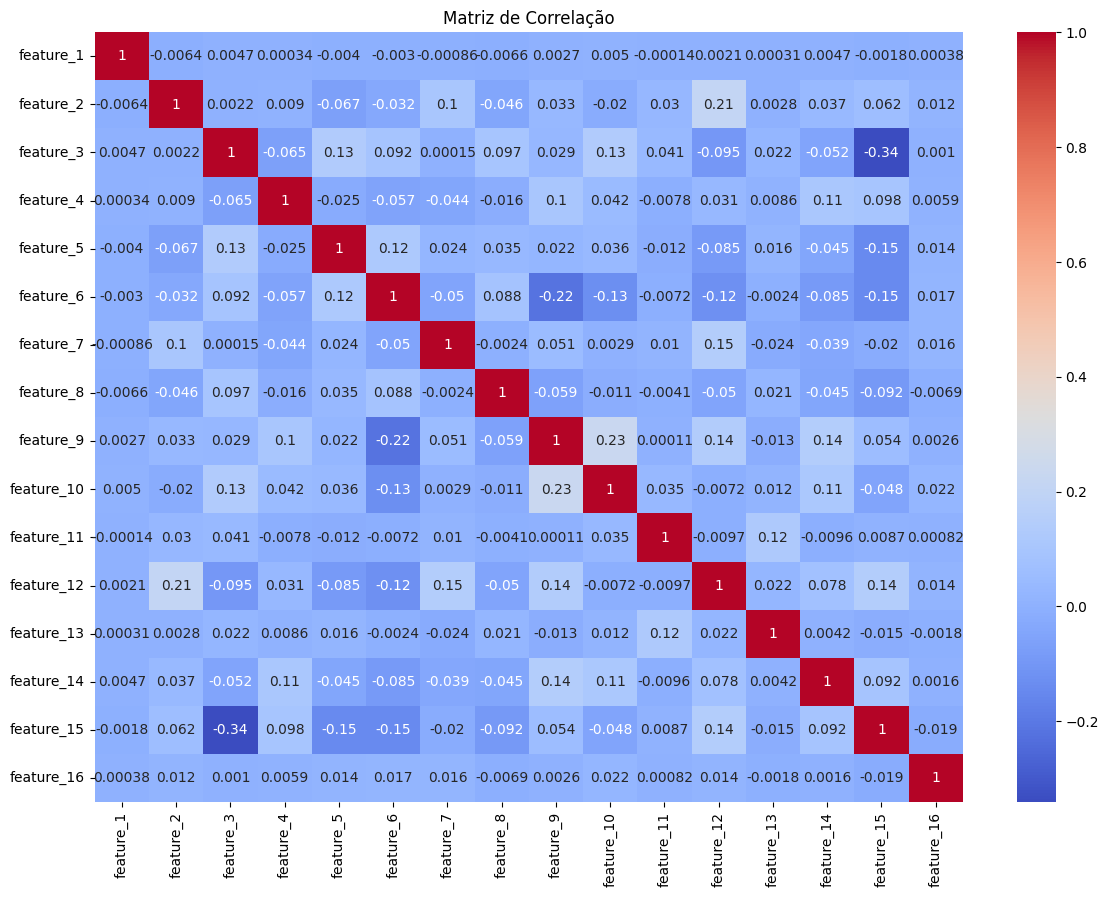

In [ ]:
# View Correlation Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Extract the values ​​from the correlation matrix
correlation_values = correlation_matrix[0].toArray()
# Get list of column names
columns = [f'feature_{i+1}' for i in range(len(correlation_values))]
# Convert array to a pandas DataFrame
corr_matrix = pd.DataFrame(correlation_values, columns=columns, index=columns)
# Generate a heatmap to visualize correlations
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()



By observation, we will remove the variable feature_3 (BusinessAcceptsBitcoin), and it has the highest negative correlation with feature_15 (WheelchairAccessible), indicating that it does not add much to the training of the model.

In [ ]:
# Define the feature vector again without the 'BusinessAcceptsBitcoin' column.
crl = control
assembler = VectorAssembler(
    inputCols= ['AcceptsInsurance',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'CoatCheck',
 'DogsAllowed',
 'DriveThru',
 'HappyHour',
 'HasTV',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsCounterService',
 'RestaurantsGoodForGroups',
 'WheelchairAccessible',
 'AgesAllowed_num'],
    outputCol="features"
)
data_features = assembler.transform(crl).select("features", "stars")
type(data_features)

In [ ]:
# Split data into training and testing
train_data, test_data = data_features.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Decision tree
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol="stars", featuresCol="features")
model_dt = dt.fit(train_data)

In [ ]:
# Make predictions on test data
predictions = model_dt.transform(test_data)

In [ ]:
# Model evaluation
evaluator = RegressionEvaluator(labelCol="stars", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE do modelo:", rmse)

RMSE do modelo: 0.5483068194095223


In [ ]:
#Random Forest
#numTrees: Number of trees in the forest (default=20)
#maxDepth: Maximum depth of trees (default=5)
#seed: Seed initialization of random numbers (default=None)
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="stars", featuresCol="features",numTrees=10, maxDepth=10,seed=123)
model_rf = rf.fit(train_data)

In [ ]:
# Making predictions on test data
predictions = model_rf.transform(test_data)

In [ ]:
# Model evaluation
evaluator = RegressionEvaluator(labelCol="stars", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE do modelo:", rmse)

RMSE do modelo: 0.5090409209385053


The best model was the Random Forest with the lowest RMSE value. The predictions are on average close to the actual values ​​(stars). We consider a good result since the model learned through characteristics and particularities of the establishments, which may or may not influence the attribution of stars by users, and also suggesting that some evaluations may have been influenced by the characteristics analyzed by the model.

#Analysis of reviews


* Use of RDD, to perform transformations and actions.

In [22]:
# Creation of the dataframe resulting from the Join executed only with columns 'stars' and 'text' with 4557625 records
# Refer to business with categories 'Restaurants'
reviews = result1
reviews = reviews.select('stars', 'text')
type(reviews)

pyspark.sql.dataframe.DataFrame

##Transformaões e ações com RDD

In [ ]:
# Create RDD and confirm type
reviews_rdd = reviews.rdd
type(reviews_rdd)

pyspark.rdd.RDD

In [ ]:
# Count records
reviews_rdd.count()

4557625

In [ ]:
# Check first 5 records
reviews_rdd.take(5)

[Row(stars=4.5, text="Ate here for the 1st time on Saturday 08/07/2020. \nThe food was ok, had the Lobster Boil . The Lobster was ok for a soft shelled Lobster. The Crabs were soggy and mushy. The Clams were gummy and snotty . The headed shrimp were large and tasty. All the items were precooked, obviously. The fish spread was decent , also had the Fried Shrimp and Shrimp scampi  which were decent. BYOB ... ... The atmosphere was nice except for the zillion Flies. I'll be back with a six pack"),
 Row(stars=4.5, text="Absolutely fantastic!!!!  I'll be back for sure. Fried lobster tail was delicious. Five star for sure."),
 Row(stars=4.5, text="I was sadly disappointed in my experience. We ordered crabs and they were extremely small, watery and over half were bad(sick crabs), we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture. The coleslaw also lacked taste. We ask for grouper nuggets and a few were not cooked all the way. So g

In [ ]:
# Apply the transform to remove the "\n" in the second element of rdd
reviews_rdd1 = reviews_rdd.map(lambda x: (x[0], x[1].replace("\n", "")))
# View 5 records
reviews_rdd1.take(5)

[(4.5,
  "Ate here for the 1st time on Saturday 08/07/2020. The food was ok, had the Lobster Boil . The Lobster was ok for a soft shelled Lobster. The Crabs were soggy and mushy. The Clams were gummy and snotty . The headed shrimp were large and tasty. All the items were precooked, obviously. The fish spread was decent , also had the Fried Shrimp and Shrimp scampi  which were decent. BYOB ... ... The atmosphere was nice except for the zillion Flies. I'll be back with a six pack"),
 (4.5,
  "Absolutely fantastic!!!!  I'll be back for sure. Fried lobster tail was delicious. Five star for sure."),
 (4.5,
  "I was sadly disappointed in my experience. We ordered crabs and they were extremely small, watery and over half were bad(sick crabs), we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture. The coleslaw also lacked taste. We ask for grouper nuggets and a few were not cooked all the way. So given the food experience it was nothin

In [ ]:
# Transformation that replaces punctuation characters and numeric digits with blanks
import string
# Define the function to apply the transform to the second element
def remove_punctuation(rdd):
    stars, text = rdd
    punctFilter = str.maketrans(string.punctuation + '0123456789', ' ' * (len(string.punctuation) + 10))
    text = text.translate(punctFilter)
    return stars, text
# Apply the function on each RDD element using map
reviews_rdd2 = reviews_rdd1.map(remove_punctuation)
# view 5 records
reviews_rdd2.take(5)

[(4.5,
  'Ate here for the  st time on Saturday             The food was ok  had the Lobster Boil   The Lobster was ok for a soft shelled Lobster  The Crabs were soggy and mushy  The Clams were gummy and snotty   The headed shrimp were large and tasty  All the items were precooked  obviously  The fish spread was decent   also had the Fried Shrimp and Shrimp scampi  which were decent  BYOB         The atmosphere was nice except for the zillion Flies  I ll be back with a six pack'),
 (4.5,
  'Absolutely fantastic      I ll be back for sure  Fried lobster tail was delicious  Five star for sure '),
 (4.5,
  'I was sadly disappointed in my experience  We ordered crabs and they were extremely small  watery and over half were bad sick crabs   we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture  The coleslaw also lacked taste  We ask for grouper nuggets and a few were not cooked all the way  So given the food experience it was nothin

In [ ]:
# Apply the count the number of words action
reviews_rdd3 = reviews_rdd2.map(lambda t: (t[0], len(t[1].split())))
# View 5 records
reviews_rdd3.take(5)

[(4.5, 84), (4.5, 17), (4.5, 175), (4.5, 13), (4.5, 29)]

In [ ]:
# Ver lista de stars existentes no RDD

# Extract 1 element from rdd
p_elemento = reviews_rdd3.map(lambda t: t[0])
# different values
val_dist = p_elemento.distinct()
# Distinct values ​​as list
list_val_dist = val_dist.collect()
list_val_dist

[4.5, 4.0, 3.5, 2.5, 3.0, 2.0, 5.0]

###Sentiment Analysis

**VADER**

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analyzer. The model was trained on social media comment text.

The objective is to train ML models with the metrics generated by the VADER sentiment analysis, and classify the comments regarding the attribution of 'stars'.

In [ ]:
# Library installation
!pip install vaderSentiment --quiet
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Selection 5000 random records
from pyspark.sql.functions import rand
from pyspark.sql.functions import col
reviews1 = df_review
# 5000 random records
reviews1 = reviews1.orderBy(rand()).limit(5000)
# Select 'stars' and 'text' columns
reviews1 = reviews1.select('stars', 'text')
type(reviews1)

pyspark.sql.dataframe.DataFrame

In [ ]:
# See scheme
reviews1.printSchema()

root
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
# View 5 records
reviews1.take(5)

[Row(stars=4.5, text="Ate here for the 1st time on Saturday 08/07/2020. \nThe food was ok, had the Lobster Boil . The Lobster was ok for a soft shelled Lobster. The Crabs were soggy and mushy. The Clams were gummy and snotty . The headed shrimp were large and tasty. All the items were precooked, obviously. The fish spread was decent , also had the Fried Shrimp and Shrimp scampi  which were decent. BYOB ... ... The atmosphere was nice except for the zillion Flies. I'll be back with a six pack", business_stars=4.5),
 Row(stars=4.5, text="Absolutely fantastic!!!!  I'll be back for sure. Fried lobster tail was delicious. Five star for sure.", business_stars=4.5),
 Row(stars=4.5, text="I was sadly disappointed in my experience. We ordered crabs and they were extremely small, watery and over half were bad(sick crabs), we ordered beans and rice which lacked flavor and literally had one bean in it that you can see from the picture. The coleslaw also lacked taste. We ask for grouper nuggets and

In [ ]:
# Create RDD to make changes to the text of reviews
rdd = reviews1.rdd

In [ ]:
# Apply the transform to remove the "\n" in the second element of rdd
rdd1 = rdd.map(lambda x: (x[0], x[1].replace("\n", "")))

In [ ]:
# Set text RDD
texto_rdd = rdd1.map(lambda t: t[1])
texto_rdd

PythonRDD[18] at RDD at PythonRDD.scala:53

In [ ]:
# Create a function to parse text using the VADER model
def analyze_sentiment(row):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(row)
    return sentiment
# Apply the function to each line of the RDD
analise_rdd = texto_rdd.map(analyze_sentiment)
type(analise_rdd)

pyspark.rdd.PipelinedRDD

In [ ]:
# View 2 records
analise_rdd.take(2)

[{'neg': 0.054, 'neu': 0.832, 'pos': 0.114, 'compound': 0.7456},
 {'neg': 0.041, 'neu': 0.779, 'pos': 0.181, 'compound': 0.6062}]

'neg': the negativity value, which indicates the probability of being a negative review. Higher values ​​indicate more negativity.

'neu': the neutrality value, which indicates the probability of being a neutral analysis. Higher values ​​indicate more neutrality.

'pos': the positivity value, which indicates the probability of being a positive analysis. Higher values ​​indicate more positivity.

'compound': the composite value, which is an aggregate score that summarizes the overall sentiment of the sentence. Values ​​greater than 0 indicate positive sentiment, values ​​less than 0 indicate negative sentiment, and values ​​close to 0 indicate neutrality.

In [ ]:
# Create dataframe with SentimentIntensityAnalyzer results
df_sentiment = spark.createDataFrame(analise_rdd)

In [ ]:
# Add the stars column to the dataframe
from pyspark.sql.functions import monotonically_increasing_id
# Select the first value from column "stars" of DataFrame "reviews" and generate 'id'
df_star = reviews1.select('stars').withColumn("id", monotonically_increasing_id())
# generate id for df_sentiment
df_sentiment = df_sentiment.withColumn("id", monotonically_increasing_id())
# Join between dataframes
df_sentiment1 = df_sentiment.join(df_star,"id", "inner")
# Delete column "id"
df_sentiment1 = df_sentiment1.drop('id')

In [ ]:
# Display 2 rows from the resulting DataFrame
df_sentiment1.show(2)

+--------+-----+-----+-----+-----+
|compound|  neg|  neu|  pos|stars|
+--------+-----+-----+-----+-----+
|  0.8597|  0.0|0.893|0.107|  3.0|
|  0.9858|0.049| 0.71|0.241|  5.0|
+--------+-----+-----+-----+-----+
only showing top 2 rows



In [ ]:
# View Resulting Columns
df_sentiment1.columns

['compound', 'neg', 'neu', 'pos', 'stars']

In [ ]:
# View schema
df_sentiment1.printSchema()

root
 |-- compound: double (nullable = true)
 |-- neg: double (nullable = true)
 |-- neu: double (nullable = true)
 |-- pos: double (nullable = true)
 |-- stars: double (nullable = true)



In [ ]:
# Drop NaN
df_sentiment1.dropna()

DataFrame[compound: double, neg: double, neu: double, pos: double, stars: double]

In [ ]:
# Check existence of nulls
from pyspark.sql.functions import sum
df_sentiment1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_sentiment1.columns]).show()

+--------+---+---+---+-----+
|compound|neg|neu|pos|stars|
+--------+---+---+---+-----+
|       0|  0|  0|  0|    0|
+--------+---+---+---+-----+



In [ ]:
# View existing 'stars' in our data selection
# Get the unique values ​​of the 'stars' column
unique_values = df_sentiment1.select('stars').distinct().collect()
# Display the unique values
for row in unique_values:
    print(row.stars)

1.0
4.0
3.0
2.0
5.0


In [ ]:
# Prepare data
from pyspark.ml.feature import VectorAssembler
crl = df_sentiment1
assembler = VectorAssembler(
    inputCols= ['neg', 'pos', 'compound', 'neu'],
    outputCol="features"
)
data_features = assembler.transform(crl).select("features", "stars")

In [ ]:
# View data_features 2 lines
data_features.take(2)

[Row(features=DenseVector([0.104, 0.095, 0.2578, 0.801]), stars=2.0),
 Row(features=DenseVector([0.07, 0.044, -0.9665, 0.886]), stars=1.0)]

In [ ]:
# View type data_features created
type(data_features)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Split data into training and testing
train_data, test_data = data_features.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
# Create a DecisionTreeClassifier model
dtc = DecisionTreeClassifier(labelCol="stars", featuresCol="features")
# Train the model using the training data
model = dtc.fit(train_data)

In [ ]:
# Make predictions on test data
predictions = model.transform(test_data)

In [ ]:
# Generate confusion matrix
from pyspark.mllib.evaluation import MulticlassMetrics
# Extract the forecasts and labels from the forecasts DataFrame
predictionAndLabels = predictions.select("prediction", "stars").rdd
# Create a MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)
# Get the confusion matrix
confusionMatrix = metrics.confusionMatrix()
# Display the confusion matrix
print("Confusion Matrix:")
print(confusionMatrix)

Confusion Matrix:
DenseMatrix([[113.,   0.,   0.,   8.,  24.],
             [ 50.,   0.,   0.,   9.,  23.],
             [ 30.,   0.,   0.,  13.,  46.],
             [ 18.,   0.,   0.,   9., 157.],
             [ 29.,   0.,   0.,  20., 409.]])


In [ ]:
# View Decision Tree model metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Criar um objeto MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="stars", predictionCol="prediction")
# Calculate the evaluation metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# Display the evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.5543
Precision: 0.3973
Recall: 0.5543
F1-score: 0.4532


In [ ]:
# Create a RandomForestClassifier model
from pyspark.ml.classification import RandomForestClassifier
# Fit model
rfc = RandomForestClassifier(numTrees=20,labelCol="stars", featuresCol="features")
# Train the model using the training data
model = rfc.fit(train_data)

In [ ]:
# Make predictions on test data
predictions = model.transform(test_data)

In [ ]:
# View predictions made by the random forest model
predictions.select('stars','prediction').show()

+-----+----------+
|stars|prediction|
+-----+----------+
|  4.0|       2.0|
|  3.0|       4.0|
|  4.0|       4.0|
|  4.0|       3.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  4.0|       5.0|
|  4.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
|  4.0|       5.0|
|  5.0|       5.0|
|  4.0|       5.0|
|  5.0|       5.0|
|  5.0|       5.0|
+-----+----------+
only showing top 20 rows



In [ ]:
# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="stars", predictionCol="prediction")
# Calculate the evaluation metrics on the test set
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
# Display the evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.5637
Precision: 0.4030
Recall: 0.5637
F1-score: 0.4525


With the metrics generated by the sentiment analysis, we built 2 models for classifying 'stars' attributed in the evaluation made of the business.
The model with the best results was RandomForest with an accuracy of 56.37%. Even so, analyzing the precission, recal and F1-score (lower), we conclude the model's difficulty in correctly classifying the positive samples.

# Conclusion
In this work, we load 2 datasets in a spak environment with almost 7 million records, which we store and process in a scalable and efficient way.

We use the flexibility of RDD to make text transformations, actions such as the word count per review in more than 4 million records.

We create, sql queries in the exploration of the data.

We set up regression models, trained with business characteristics, to predict business stars.

We also performed a sentiment analysis of the evaluations made in a sample of 5000 records, and used the metrics generated by the VADER model, to train classification models that could assign the stars associated with the evaluations.

The Spark distributed environment allows us to work with large volumes of data in a distributed way, being able to process data efficiently.
Despite Google Colab having some limitations, we managed to get a general perspective of how data is stored and processed using Spark.